In [27]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from random import randint

In [28]:
POPULATION_SIZE = None
INDIVIDUAL_LENGTH = None
CROSSOVER_RATE = None
MUTATION_RATE = None

generation_count = None
population = None
fitness_values = None
probs = None
best_value = None
best_individual = None
cities = None
cost_matrix = None

In [29]:
def init():
    global POPULATION_SIZE, INDIVIDUAL_LENGTH, CROSSOVER_RATE, MUTATION_RATE, generation_count, population, fitness_values, best_value, best_individual, cities, cost_matrix
    POPULATION_SIZE = 30
    INDIVIDUAL_LENGTH = 734
    CROSSOVER_RATE = 0.9
    MUTATION_RATE = 0.01
    
    generation_count = 200
    population = np.zeros((POPULATION_SIZE, INDIVIDUAL_LENGTH)).astype(int)
    file = open("data/uy734.tsp", "r")
#     cities = np.zeros((INDIVIDUAL_LENGTH,2))
    cities = []
    lines_skip = 7
    best_value = 1e9
    for i in file.read().split('\n')[lines_skip:lines_skip + INDIVIDUAL_LENGTH]:
        cities.append([float(i.split()[1]), float(i.split()[2])])
    cost_matrix = np.zeros((INDIVIDUAL_LENGTH, INDIVIDUAL_LENGTH))
    for i in range(INDIVIDUAL_LENGTH):
        for j in range(INDIVIDUAL_LENGTH):
            cost_matrix[i,j] = np.linalg.norm(np.array(cities[i]) - np.array(cities[j]))

In [30]:
def init_population():
    global POPULATION_SIZE, INDIVIDUAL_LENGTH, population
    individual = np.arange(INDIVIDUAL_LENGTH)
    np.random.shuffle(individual)

    for i in range(POPULATION_SIZE):
        np.random.shuffle(individual)
        idx = np.argmin(individual)
        population[i] = individual

In [31]:
def evaluate():
    global population, INDIVIDUAL_LENGTH, POPULATION_SIZE, fitness_values, probs, best_value, best_individual
    fitness_values = []
    probs = []
    for i in range(population.shape[0]):
        fitness = 0
        for j in range(population.shape[1]):
            if(j == 0):
                continue
            fitness += cost_matrix[int(population[i,j]), int(population[i,j-1])]
        fitness += cost_matrix[int(population[i,0]), int(population[i,INDIVIDUAL_LENGTH-1])]
        fitness_values.append(fitness)
    
    if(best_value > np.min(fitness_values)):
        best_value = np.min(fitness_values)
        best_individual = population[np.argmin(fitness_values)]
    
    probs = fitness_values / np.sum(fitness_values)
    probs = [[value,key] for (value,key) in sorted([(value,key) for (key,value) in enumerate(probs)])]
    for i in range(population.shape[0]):
        if(i==0):
            continue
        probs[i][0] += probs[i-1][0]
    return None

In [32]:
#sequential constructive crossover
def SCX(P1,P2,val):
    global INDIVIDUAL_LENGTH
    offspring = []
    offspring.append(0)
    
    mask = np.ones(INDIVIDUAL_LENGTH).astype(int)
    mask[0] = 0
    
    next_dp1 = np.zeros(INDIVIDUAL_LENGTH).astype(int)
    next_dp2 = np.zeros(INDIVIDUAL_LENGTH).astype(int)
    
    curr = (np.where(P1 == 0)[0][0] + val)%INDIVIDUAL_LENGTH
    next_dp1[0] = P1[curr]
    
    while(P1[curr] != 0):
        idx = np.where(P1 == P1[curr])[0][0]
        idx = (idx+val)%INDIVIDUAL_LENGTH
        next_dp1[P1[curr]] = P1[idx]
        curr = idx
        
    curr = (np.where(P2 == 0)[0][0] + val)%INDIVIDUAL_LENGTH
    next_dp2[0] = P2[curr]
    while(P2[curr] != 0):
        idx = np.where(P2 == P2[curr])[0][0]
        idx = (idx+val)%INDIVIDUAL_LENGTH
        next_dp2[P2[curr]] = P2[idx]
        curr = idx

    while(len(offspring) < INDIVIDUAL_LENGTH):
        last_node = offspring[-1]
        dp1 = last_node
        dp2 = last_node 
        while(mask[int(dp1)] == 0):
            dp1 = next_dp1[int(dp1)]
        while(mask[int(dp2)] == 0):
            dp2 = next_dp2[int(dp2)]
        if(cost_matrix[int(last_node), int(dp1)] <= cost_matrix[int(last_node), int(dp2)]):
            offspring.append(int(dp1))
            mask[int(dp1)] = 0
        else:
            offspring.append(dp2)
            mask[int(dp2)] = 0
    return offspring

In [33]:
#partially mapped crossover
def PMX(P1,P2):
    global INDIVIDUAL_LENGTH
    offspring1 = P1.copy()
    offspring2 = P2.copy()
    
    next_dp1 = np.zeros(INDIVIDUAL_LENGTH).astype(int)
    next_dp2 = np.zeros(INDIVIDUAL_LENGTH).astype(int)
    
    for idx, val in enumerate(P1):
        next_dp1[int(val)] = idx
    for idx, val in enumerate(P2):
        next_dp2[int(val)] = idx
    
    m = randint(0, INDIVIDUAL_LENGTH)
    
    for index in range(m, int(m +INDIVIDUAL_LENGTH/2)):
        i = index%INDIVIDUAL_LENGTH
        idx = next_dp1[P2[i]]
        offspring1[i], offspring1[idx] = offspring1[idx], offspring1[i]
    
    for index in range(m, int(m +INDIVIDUAL_LENGTH/2)):
        i = index%INDIVIDUAL_LENGTH
        idx = next_dp2[P1[i]]
        offspring2[i], offspring2[idx] = offspring2[idx], offspring2[i]
    
    return offspring1, offspring2

In [34]:
def mutate(individual, prob):
    global INDIVIDUAL_LENGTH, population
    if(prob >= 0.5):
        m = INDIVIDUAL_LENGTH
        n = 0
        while(n < m or m ==0):
            m = randint(1, INDIVIDUAL_LENGTH)
            n = randint(1, INDIVIDUAL_LENGTH)
        individual[m:n] = individual[m:n][::-1]
    else:
        m = INDIVIDUAL_LENGTH
        n = 0
        while(n <= m or m ==0):
            m = randint(1, INDIVIDUAL_LENGTH)
            n = randint(1, INDIVIDUAL_LENGTH)
        clone = individual.copy()
        individual[1:(n-m+1)], individual[(n-m+1):n] = clone[m:n], clone[1:m]
    return individual

In [35]:
def mutation():
    global population, MUTATION_RATE, POPULATION_SIZE
    for i in range(POPULATION_SIZE):
        if(i==0):
            continue
        if(np.random.sample() < MUTATION_RATE):
            population[i] = mutate(population[i].copy(),np.random.sample())


In [36]:
def crossover():
    global population, POPULATION_SIZE, CROSSOVER_RATE
    crossover_list = []
    for i in range(POPULATION_SIZE):
        if(np.random.sample() < CROSSOVER_RATE):
            crossover_list.append(i)
    np.random.shuffle(crossover_list)
    for i in range(0, len(crossover_list)-1, 2):
        idx1 = crossover_list[i]
        idx2 = crossover_list[i+1]
        population[idx1], population[idx2] = SCX(population[idx1].copy(), population[idx2].copy(), 1), SCX(population[idx1].copy(), population[idx2].copy(), -1)
#         population[idx1], population[idx2] = PMX(population[idx1].copy(), population[idx2].copy())
    

In [37]:
def select(prob):
    for i in range(POPULATION_SIZE):
        if(probs[i][0] >= prob):
            return population[probs[i][1]]
    return population[probs[POPULATION_SIZE-1][1]]

In [38]:
def selection():
    global population, probs, POPULATION_SIZE
    parents = np.zeros((POPULATION_SIZE, INDIVIDUAL_LENGTH)).astype(int)
    init_count = 7
    parents[0:init_count] = population[[key for [value,key] in probs[POPULATION_SIZE-init_count:POPULATION_SIZE]]]
    for i in range(init_count, POPULATION_SIZE):
        parents[i] = select(np.random.sample())
    population = parents

In [39]:
init()
init_population()

In [40]:
generation_count = 500
for i in range(generation_count):
    print("Generation", i+1)
    evaluate()
    print("Best value generation", np.min(fitness_values))
    print("Best value", best_value)
    selection()
    crossover()
    mutation()


Generation 1
Best value generation 1565572.113512379
Best value 1565572.113512379
Generation 2
Best value generation 1216051.3581516633
Best value 1216051.3581516633
Generation 3
Best value generation 981475.5234520561
Best value 981475.5234520561
Generation 4
Best value generation 834696.3444177562
Best value 834696.3444177562
Generation 5
Best value generation 744855.9272342143
Best value 744855.9272342143
Generation 6
Best value generation 672153.4320652691
Best value 672153.4320652691
Generation 7
Best value generation 608820.420514753
Best value 608820.420514753
Generation 8
Best value generation 561855.9670428509
Best value 561855.9670428509
Generation 9
Best value generation 502195.5851427566
Best value 502195.5851427566
Generation 10
Best value generation 462059.0273708765
Best value 462059.0273708765
Generation 11
Best value generation 427265.363166701
Best value 427265.363166701
Generation 12
Best value generation 398989.8062050194
Best value 398989.8062050194
Generation 13
B

Generation 99
Best value generation 109388.94852572995
Best value 105142.44877395361
Generation 100
Best value generation 112780.49095799756
Best value 105142.44877395361
Generation 101
Best value generation 110879.38289973306
Best value 105142.44877395361
Generation 102
Best value generation 107865.40687056351
Best value 105142.44877395361
Generation 103
Best value generation 102493.08099462165
Best value 102493.08099462165
Generation 104
Best value generation 106368.07299170106
Best value 102493.08099462165
Generation 105
Best value generation 103333.90575904376
Best value 102493.08099462165
Generation 106
Best value generation 103333.90575904376
Best value 102493.08099462165
Generation 107
Best value generation 104664.64801734463
Best value 102493.08099462165
Generation 108
Best value generation 103479.20924743351
Best value 102493.08099462165
Generation 109
Best value generation 101787.39972285276
Best value 101787.39972285276
Generation 110
Best value generation 98198.83933247135


Generation 197
Best value generation 93579.1209249818
Best value 90280.28105716984
Generation 198
Best value generation 93066.34364415413
Best value 90280.28105716984
Generation 199
Best value generation 92697.29252725471
Best value 90280.28105716984
Generation 200
Best value generation 93464.40098306922
Best value 90280.28105716984
Generation 201
Best value generation 92729.45289261805
Best value 90280.28105716984
Generation 202
Best value generation 92602.46443721588
Best value 90280.28105716984
Generation 203
Best value generation 95255.50604329651
Best value 90280.28105716984
Generation 204
Best value generation 92527.31103039677
Best value 90280.28105716984
Generation 205
Best value generation 92716.70404155341
Best value 90280.28105716984
Generation 206
Best value generation 93282.34543674946
Best value 90280.28105716984
Generation 207
Best value generation 92977.38878721402
Best value 90280.28105716984
Generation 208
Best value generation 95046.89799944838
Best value 90280.28105

Generation 295
Best value generation 91593.17204454125
Best value 90280.28105716984
Generation 296
Best value generation 89937.69177653876
Best value 89937.69177653876
Generation 297
Best value generation 89892.42336992665
Best value 89892.42336992665
Generation 298
Best value generation 92345.46849964661
Best value 89892.42336992665
Generation 299
Best value generation 92215.91267940986
Best value 89892.42336992665
Generation 300
Best value generation 93366.86308888688
Best value 89892.42336992665
Generation 301
Best value generation 94602.19656307866
Best value 89892.42336992665
Generation 302
Best value generation 91440.72958879576
Best value 89892.42336992665
Generation 303
Best value generation 92122.57561786857
Best value 89892.42336992665
Generation 304
Best value generation 92122.57561786857
Best value 89892.42336992665
Generation 305
Best value generation 91024.52308278847
Best value 89892.42336992665
Generation 306
Best value generation 91024.52308278847
Best value 89892.4233

Generation 393
Best value generation 91936.47062171683
Best value 89036.64771973909
Generation 394
Best value generation 92110.57528932033
Best value 89036.64771973909
Generation 395
Best value generation 92110.57528932033
Best value 89036.64771973909
Generation 396
Best value generation 93094.22113796264
Best value 89036.64771973909
Generation 397
Best value generation 93284.51923215459
Best value 89036.64771973909
Generation 398
Best value generation 94506.37571519574
Best value 89036.64771973909
Generation 399
Best value generation 91608.86647535222
Best value 89036.64771973909
Generation 400
Best value generation 94988.05996845286
Best value 89036.64771973909
Generation 401
Best value generation 95310.1411723965
Best value 89036.64771973909
Generation 402
Best value generation 93402.83796789096
Best value 89036.64771973909
Generation 403
Best value generation 96136.0181916551
Best value 89036.64771973909
Generation 404
Best value generation 94414.59439021203
Best value 89036.647719

Generation 491
Best value generation 96871.32389705564
Best value 89036.64771973909
Generation 492
Best value generation 97262.87680755655
Best value 89036.64771973909
Generation 493
Best value generation 95634.98813763498
Best value 89036.64771973909
Generation 494
Best value generation 94977.33555280081
Best value 89036.64771973909
Generation 495
Best value generation 96213.54898508627
Best value 89036.64771973909
Generation 496
Best value generation 96830.16865100854
Best value 89036.64771973909
Generation 497
Best value generation 95947.58827349372
Best value 89036.64771973909
Generation 498
Best value generation 95947.58827349372
Best value 89036.64771973909
Generation 499
Best value generation 94867.41650407232
Best value 89036.64771973909
Generation 500
Best value generation 96799.4436577096
Best value 89036.64771973909


89036.64771973909


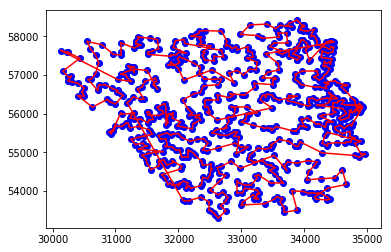

In [41]:
print(best_value)
plot_cities = np.array(cities)
plt.plot(plot_cities[:,0], plot_cities[:,1], 'bo')
for i in range(INDIVIDUAL_LENGTH):
    if(i == 0):
        city_idx_prev = int(best_individual[0])
        city_idx = int(best_individual[INDIVIDUAL_LENGTH-1])
        plt.plot(plot_cities[(city_idx_prev,city_idx),0], plot_cities[(city_idx_prev,city_idx),1], 'r-')
        continue
    city_idx_prev = int(best_individual[i-1])
    city_idx = int(best_individual[i])
    plt.plot(plot_cities[(city_idx_prev,city_idx),0], plot_cities[(city_idx_prev,city_idx),1], 'r-')
    
plt.show()